In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
from mpl_toolkits.mplot3d import Axes3D
from compartmentalModel import compartmentalModel

In [2]:
data = pd.read_csv('caso_full.csv')

In [3]:
data.columns

Index(['city', 'city_ibge_code', 'date', 'epidemiological_week',
       'estimated_population', 'estimated_population_2019', 'is_last',
       'is_repeated', 'last_available_confirmed',
       'last_available_confirmed_per_100k_inhabitants', 'last_available_date',
       'last_available_death_rate', 'last_available_deaths', 'order_for_place',
       'place_type', 'state', 'new_confirmed', 'new_deaths'],
      dtype='object')

## Data ingestion

In [4]:
mapping = {}
mapping['AC'] = "Norte"
mapping['AL'] = "Nordeste"
mapping['AM'] = "Norte"
mapping['AP'] = "Norte"
mapping['BA'] = "Nordeste"
mapping['CE'] = "Nordeste"
mapping['DF'] = "Centro Oeste"
mapping['ES'] = "Sudeste"
mapping['GO'] = "Centro Oeste"
mapping['MA'] = "Nordeste"
mapping['MG'] = "Sudeste"
mapping['MS'] = "Centro Oeste"
mapping['MT'] = "Centro Oeste"
mapping['PA'] = "Norte"
mapping['PB'] = "Nordeste"
mapping['PE'] = "Nordeste"
mapping['PI'] = "Nordeste"
mapping['PR'] = "Sul"
mapping['RJ'] = "Sudeste"
mapping['RN'] = "Nordeste"
mapping['RO'] = "Centro Oeste"
mapping['RR'] = "Norte"
mapping['RS'] = "Sul"
mapping['SC'] = "Sul"
mapping['SE'] = "Nordeste"
mapping['SP'] = "Sudeste"
mapping['TO'] = "Norte"

In [5]:
field = "last_available_confirmed"
data = data[(data['city'].isnull() == False) & (data['is_repeated'] == False)]
columns_to_drop = ['city','place_type',
                   'last_available_date','estimated_population',
                   'is_last','is_repeated']
data['date'] = pd.to_datetime(data['date'],format='%Y-%m-%d')
data['region'] = data.apply (lambda row: mapping[row["state"]], axis=1)
pop_estimation = data[["estimated_population","region"]].groupby("region").sum()
data.drop(columns=columns_to_drop,inplace=True)

In [6]:
data["state"].nunique()

27

In [7]:
data.region.unique()

array(['Norte', 'Nordeste', 'Centro Oeste', 'Sudeste', 'Sul'],
      dtype=object)

### Interpolate missing data

In [8]:
min_date = data["date"].min()
max_date = data["date"].max()
delta = max_date - min_date
dates = pd.date_range(start=min_date, end=max_date, freq='D')
def interpolate_mun(mun_data,field):
    #series = mun_data[["last_available_confirmed_per_100k_inhabitants","date","region"]]
    series = mun_data[[field,"date","region"]]
    region_ = series.iloc[0].region
    series = series.set_index("date").reindex(dates).interpolate().ffill().fillna(0)
    series["region"] = region_
    return series

### Aggregate week data at each region

In [9]:
agg_data = data[[field,"city_ibge_code","region","date"]]\
                            .groupby("city_ibge_code")\
                            .apply(lambda x: interpolate_mun(x,field))
agg_data["deaths"] = data[["new_deaths","city_ibge_code","region","date"]]\
                            .groupby("city_ibge_code")\
                            .apply(lambda x: interpolate_mun(x,"new_deaths"))["new_deaths"]
agg_data = agg_data.reset_index()
agg_data.rename(columns={"level_1": "date"},inplace=True)
agg_data = agg_data[[field,"deaths","region","date"]].groupby(['region',"date"]).sum()
grouped = agg_data.reset_index().groupby("region")
infected = np.zeros((len(grouped),delta.days + 1))
deaths = np.zeros((len(grouped),delta.days + 1))
for i,(group, data_) in enumerate(grouped):
    series = data_[[field,"date"]]
    print(i,group)
    series = series.set_index("date").reindex(dates).interpolate().ffill().fillna(0)
    infected[i,:] = series.values.reshape(len(series))
    series = data_[["deaths","date"]]
    series = series.set_index("date").reindex(dates).interpolate().ffill().fillna(0)
    deaths[i,:] = series.values.reshape(len(series))

0 Centro Oeste
1 Nordeste
2 Norte
3 Sudeste
4 Sul


In [10]:
labels = ["Centro Oeste","Nordeste","Norte","Sudeste","Sul"]

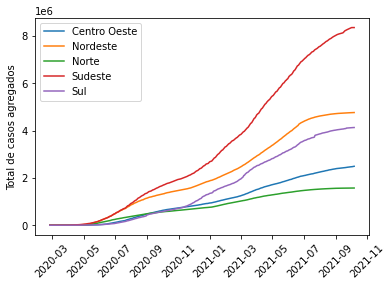

In [11]:
for i in range(5):
    plt.plot(dates,infected[i,:],label=labels[i])
plt.legend()
plt.ylabel("Total de casos agregados")
plt.xticks(rotation=45)
plt.show()

In [12]:
dim = int(np.floor(infected.shape[1]/7))
Y = np.zeros(( 5, dim)) # numero infectados na i-esima regiao na semana t 
D = np.zeros((5,dim)) # numero de mortes
for t in range(dim):
    for i in range(5):
        if t < dim - 1:
            Y[i,t] = infected[i,7*t+7] - infected[i,7*t]
            D[i,t] = np.sum(deaths[i,7*t:7*t+7])
        else:
            Y[i,t] = infected[i,-1]- infected[i,7*t]
            D[i,t] = np.sum(deaths[i,7*t:])

In [13]:
Y.shape

(5, 84)

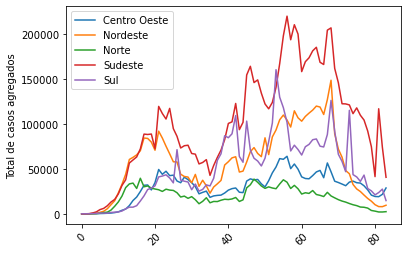

In [14]:
for i in range(5):
    plt.plot(Y[i,:],label=labels[i])
plt.legend()
plt.ylabel("Total de casos agregados")
plt.xticks(rotation=45)
plt.show()

## Make predictions with SimpleExponetial Smoothing

In [15]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

In [16]:
# pop_estimation/=1e3

In [17]:
n = 1
k = 3

In [18]:
Y /= 1e3
Y += 1e-8

In [19]:
pred = np.zeros(( 5, dim))
for i in range(5):
    ses_model = SimpleExpSmoothing(Y[i,:]).fit()
    pred[i,:] = ses_model.predict(start=0,end=dim - 1)
#     model = compartmentalModel(Y[i,:],D[i,:],pop_estimation.iloc[i],44258,25260,26170,1.5,0.02,0.01)
#     pred[i,:] = model.fit_predict()[:,0]

/home/dell/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


In [20]:
np.sum(np.abs(1 - pred/Y))

1154405.4900902915

In [21]:
# pred = np.zeros(( 5, 35))
# for i in range(5):
#     model = compartmentalModel(Y[i,:35],D[i,:35],pop_estimation.iloc[i],44258,25260,26170,1.5,0.02,0.01)
#     pred[i,:] = model.fit_predict()[:,0]

In [22]:
pred.shape

(5, 84)

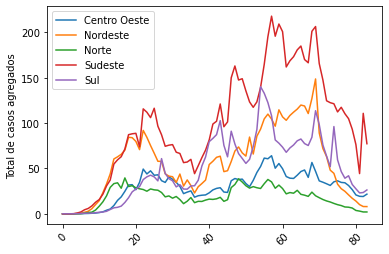

In [23]:
for i in range(5):
    plt.plot(pred[i,:],label=labels[i])
plt.legend()
plt.ylabel("Total de casos agregados")
plt.xticks(rotation=45)
plt.show()

In [24]:
#Constroi matriz de Adjacencias:
# 0 - Norte
# 1 - Centro Oeste
# 2 - Nordeste
# 3 - Sudeste
# 4 - Sul

In [25]:
A = np.zeros((5,5))

In [26]:
A[0,0] = A[0,1] = A[0,2] = A[1,0] = A[2,0] = 1
A[1,1] = A[1,2] = A[1,3] = A[1,4] = A[2,1] = A[3,1] = A[4,1] = 1
A[2,2] = A[2,3] = A[3,2] = 1
A[3,3] = A[3,4] = A[4,3] = 1
A[4,4] = 1

In [27]:
np.allclose(A,A.T)

True

In [28]:
def make_constraints(Y,pred=[],use_preds=False):
    shape = Y.shape
    Y_hat = cp.Variable(shape)
    C = [cp.Variable((shape[0],shape[0])) for i in range(k)]
    C.append(cp.Variable((shape[0],shape[0])))
    constraints = []
    for i in range(shape[0]):
         for t in range(shape[1]-n):
            terms = []
            for j in range(shape[0]):
                for l in range(min(t,k)):     
                    terms.append(C[l][i,j]*Y[j,t-l])
                if use_preds and (len(pred) >0):
                    terms.append(C[-1][i,j]*pred[j,t+n]) # termo que depende das previsoes do compartmental model
            constraints += [Y_hat[i,t+n] == cp.sum(terms)]
    return constraints,C,Y_hat

In [29]:
constraints,C,Y_hat = make_constraints(Y.copy())
lambda_ = 1
obj = cp.Minimize(cp.sum_squares(Y_hat[:,n:] - Y[:,n:]) + lambda_*cp.norm1(cp.hstack(C)))
p = cp.Problem(obj,constraints)
p.solve()

51120.07324080055

In [30]:
C[0].value

array([[ 7.96839930e-01, -7.00673930e-02,  1.53481726e-01,
        -6.98286426e-03,  5.97852731e-02],
       [ 3.88331896e-01,  8.24238868e-01,  4.22712455e-01,
         7.36485429e-02, -6.28561990e-02],
       [-1.94714104e-01,  6.73972062e-02,  1.00644611e+00,
         7.15444576e-03,  1.71078898e-04],
       [ 1.03304575e+00,  5.53899210e-01,  1.09981236e+00,
         2.67416363e-01, -5.88062283e-02],
       [ 5.69813389e-01,  5.08680302e-01, -2.54496079e-01,
        -1.13621833e-01,  5.42924578e-01]])

In [31]:
def make_plot_Y(Y,Y_hat):
    l = ["Centro Oeste","Nordeste","Norte","Sudeste","Sul"]
    for i in range(5):
        plt.plot(abs(Y[i,:] - Y_hat.value[i,:]),label=l[i])
    plt.legend()
    plt.ylabel("predict vs real")
    plt.xticks(rotation=45)
    text = f"\n Total error: {np.sum(np.abs(1 - Y_hat.value/Y)) :.2f}"
#     plt.text(0.7, 0.9,text)
    plt.title(text)
    plt.savefig(f"errors_lambda_{l}.png")
    plt.show()

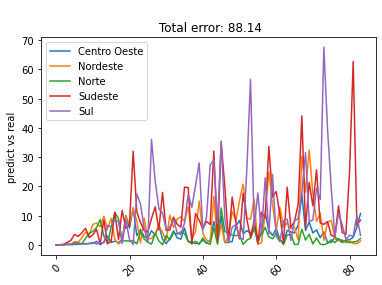

In [32]:
make_plot_Y(Y,Y_hat)

In [33]:
constraints,C,Y_hat = make_constraints(Y.copy(),pred,True)
lambda_ = 1
obj = cp.Minimize(cp.sum_squares(Y_hat[:,n:] - Y[:,n:]) + lambda_*cp.norm1(cp.hstack(C)))
p = cp.Problem(obj,constraints)
p.solve()

50214.57358513518

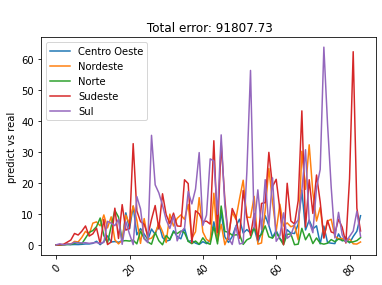

In [34]:
make_plot_Y(Y,Y_hat)

In [35]:
def make_plot_C(C,l):
    a = np.array([C[i].value for i in range(k)])
    plt.hist(a.flat)
    plt.title(f"Distribution of parameters for $\lambda$={l}")
    plt.show()

In [36]:
def make_plot_C_3d(C,l):
    bins = np.linspace(-1.5, 1.5, 25)
    for i in range(len(C)):
        a = C[i].value
        plt.hist(a.flat,bins,alpha=0.5,label=f"lag = {i+1}")
    plt.title(f"Distribution of parameters for $\lambda$={l} over time")
    plt.legend()
    plt.savefig(f"dist_time_lambda_{l}.png")
    plt.show()

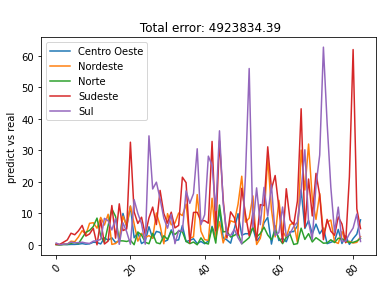

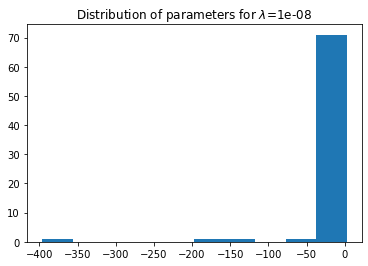

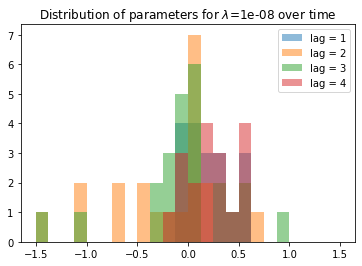

------------------------


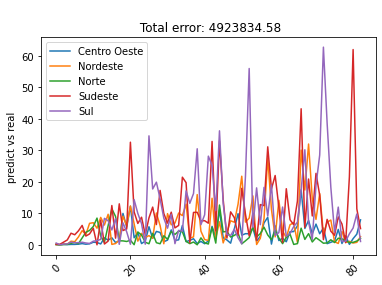

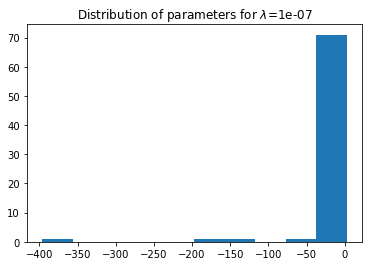

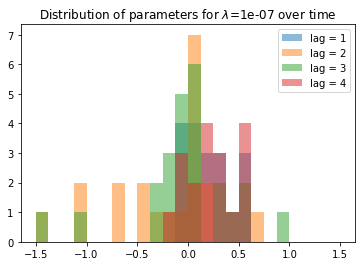

------------------------


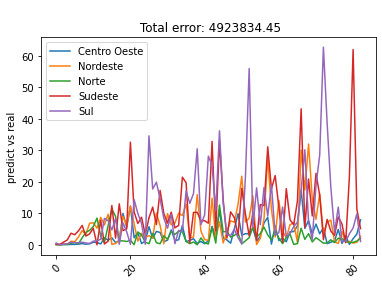

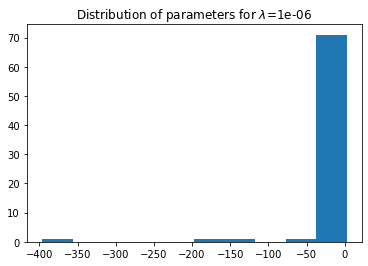

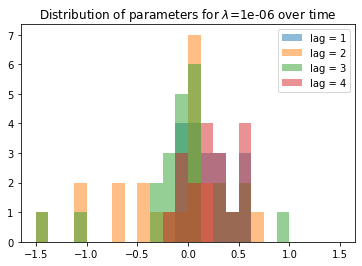

------------------------


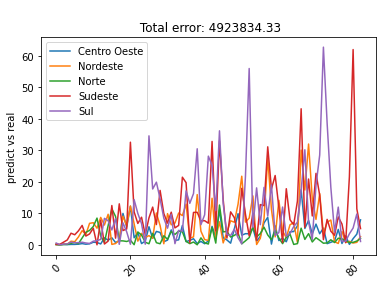

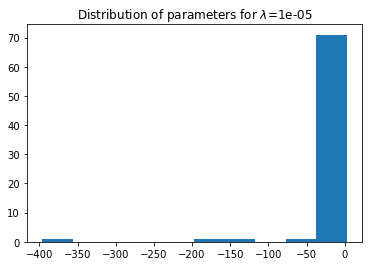

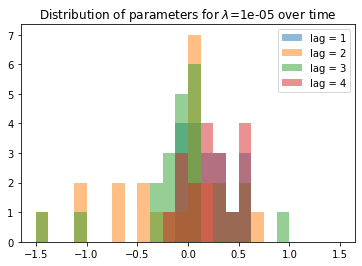

------------------------


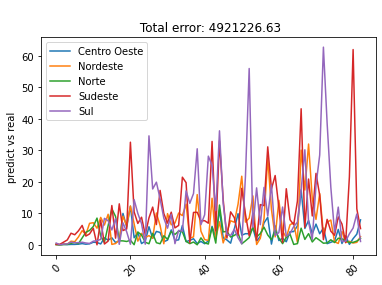

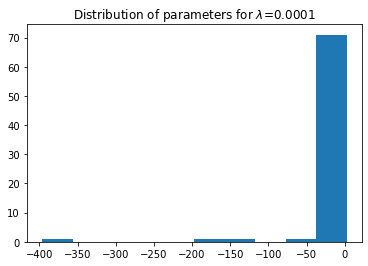

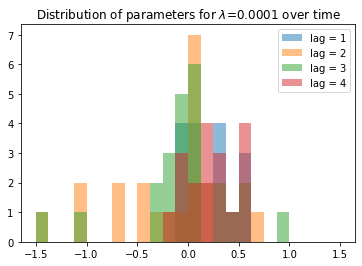

------------------------


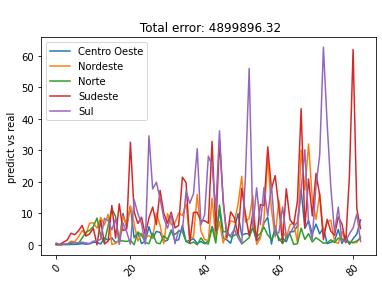

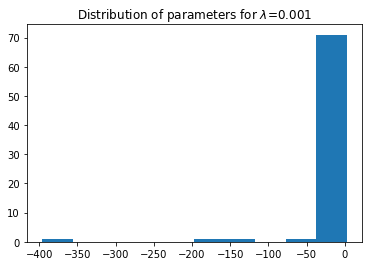

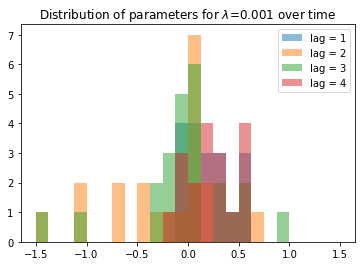

------------------------


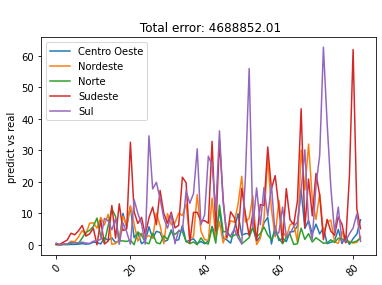

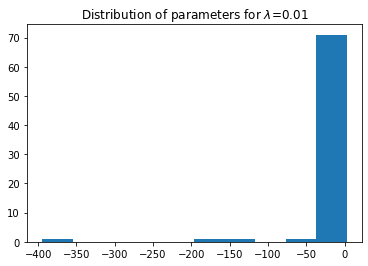

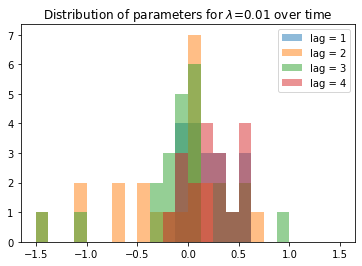

------------------------


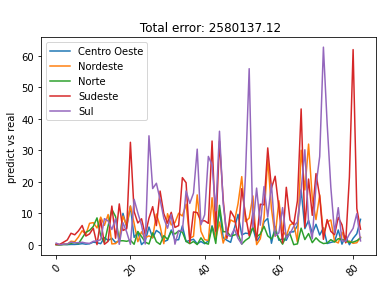

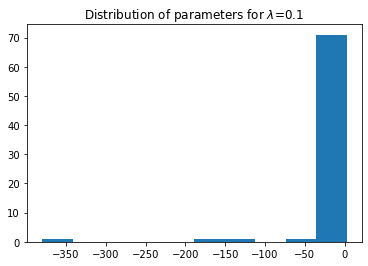

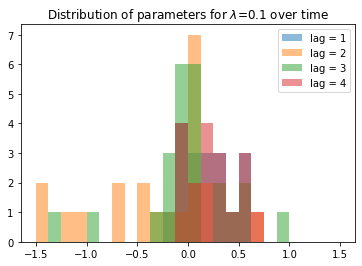

------------------------


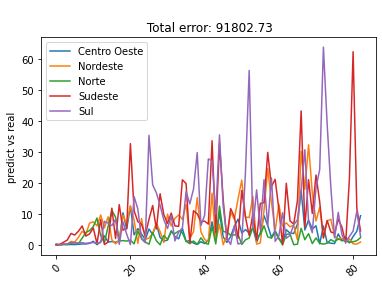

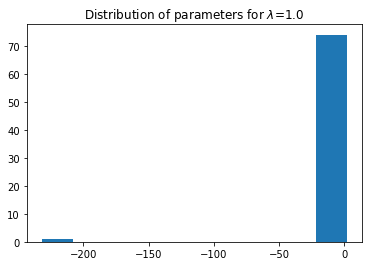

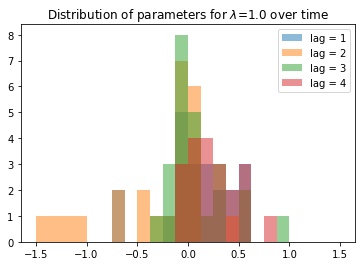

------------------------


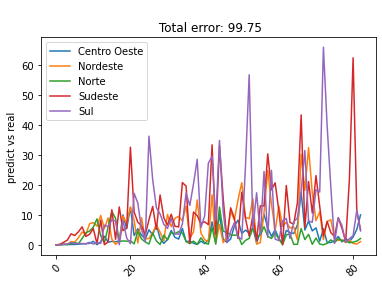

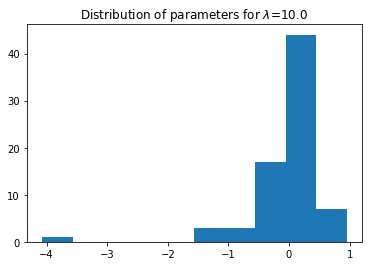

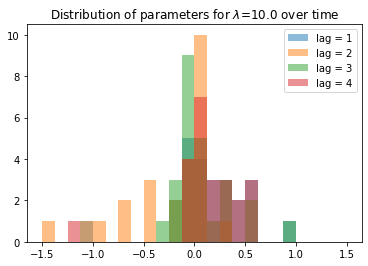

------------------------


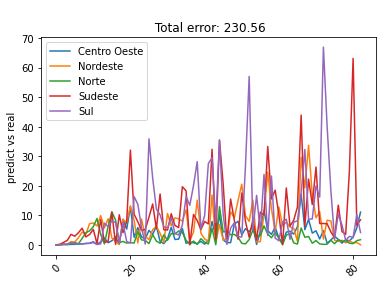

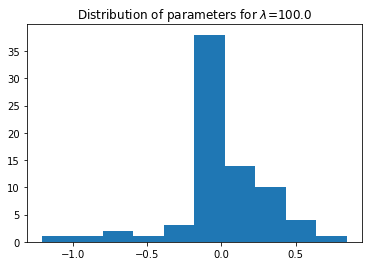

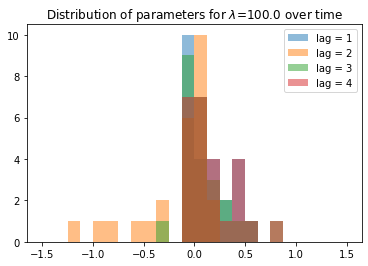

------------------------


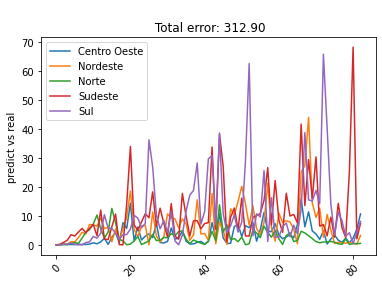

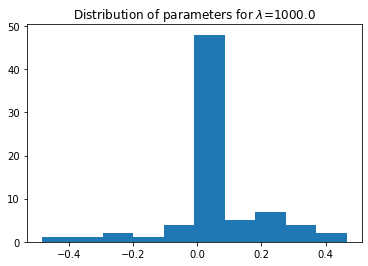

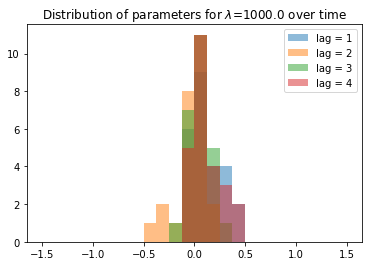

------------------------


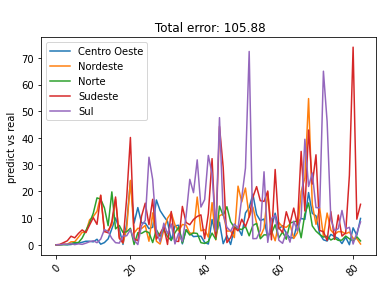

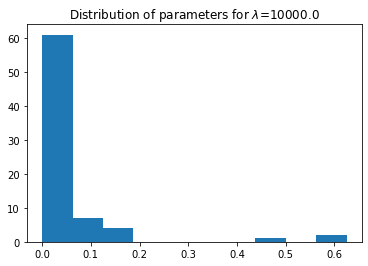

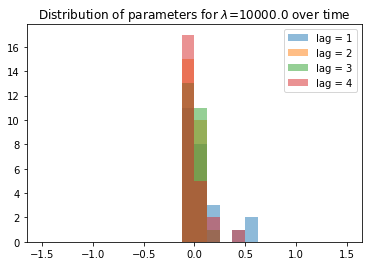

------------------------


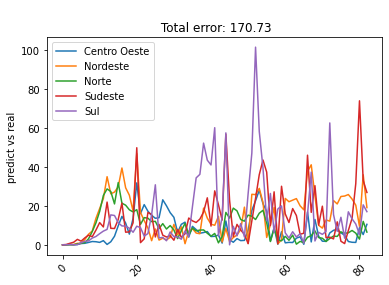

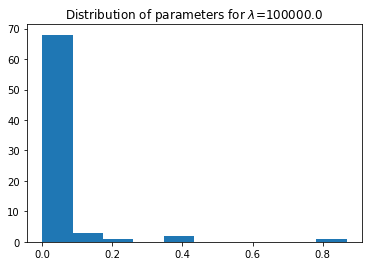

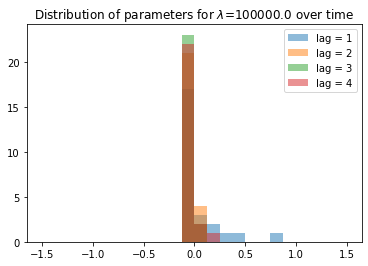

------------------------


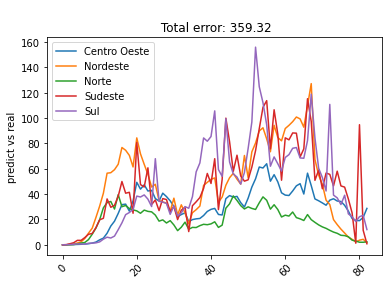

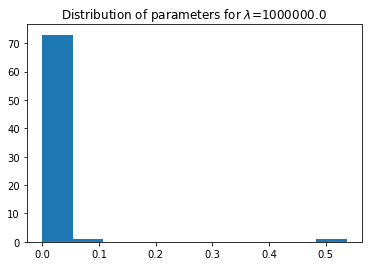

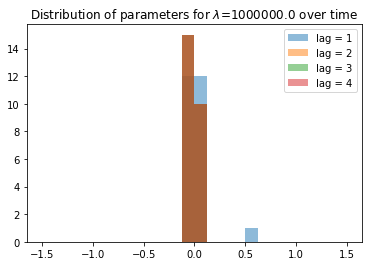

------------------------


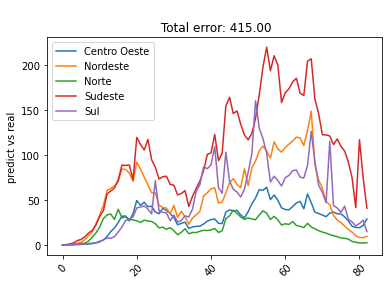

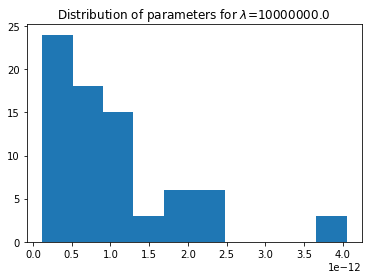

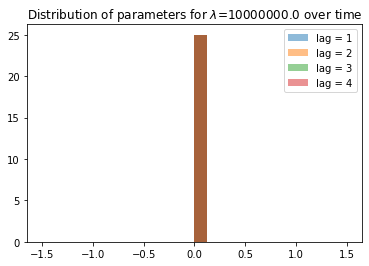

------------------------


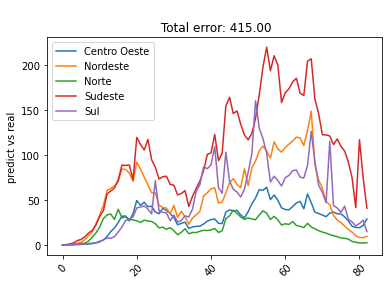

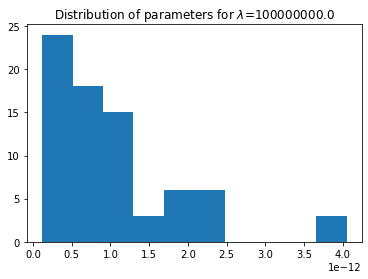

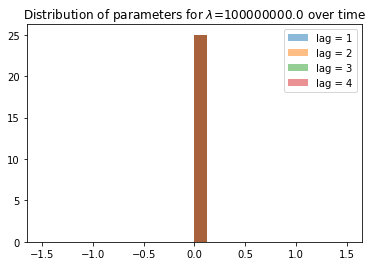

------------------------


In [58]:
with_preds = []
lambdas = np.logspace(-8,8,17)
for lambda_ in lambdas:
    constraints,C,Y_hat = make_constraints(Y.copy(),pred,True)
    obj = cp.Minimize(cp.sum_squares(Y_hat[:,n:] - Y[:,n:]) + lambda_*cp.norm1(cp.hstack(C)))
    p = cp.Problem(obj,constraints)
    p.solve()
    with_preds.append(np.sum(np.abs(1 - Y_hat[:,n:].value/Y[:,n:])))
    make_plot_Y(Y[:,n:],Y_hat[:,n:])
    make_plot_C(C,lambda_)
    make_plot_C_3d(C,lambda_)
    print("------------------------")

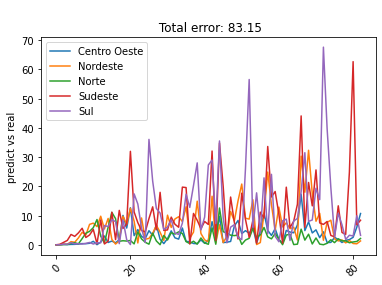

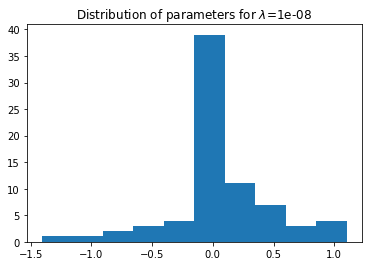

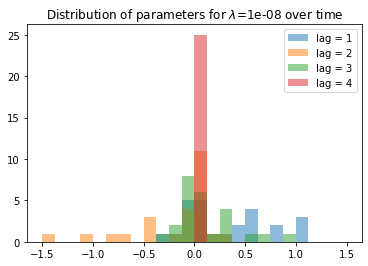

------------------------


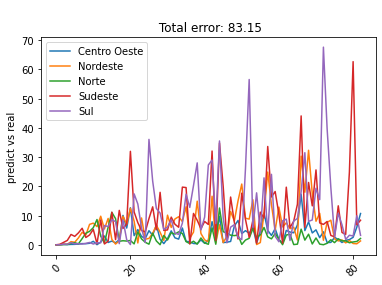

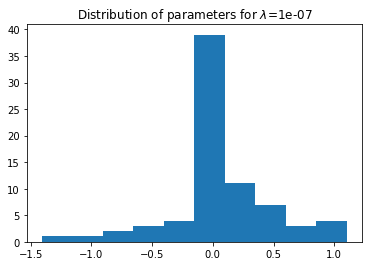

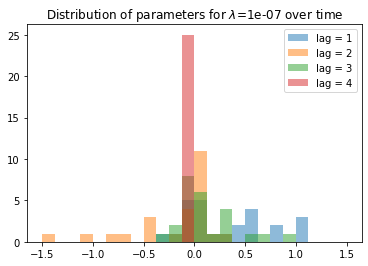

------------------------


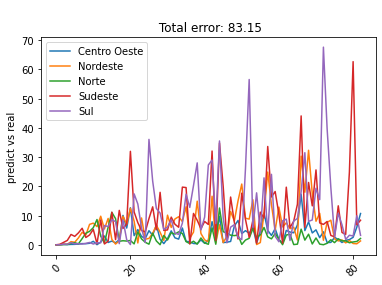

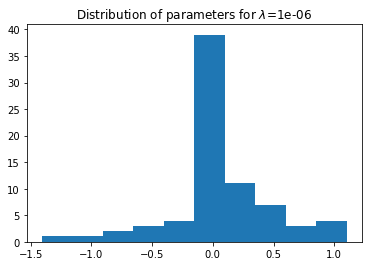

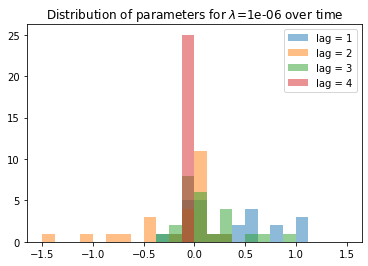

------------------------


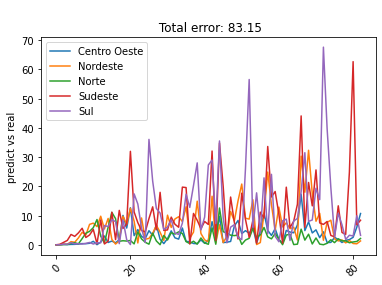

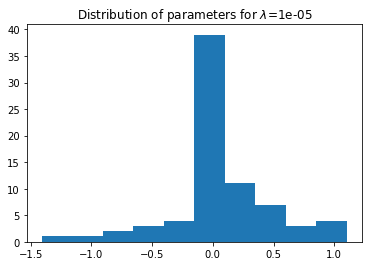

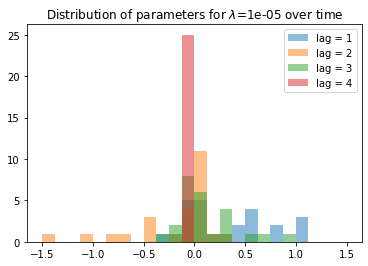

------------------------


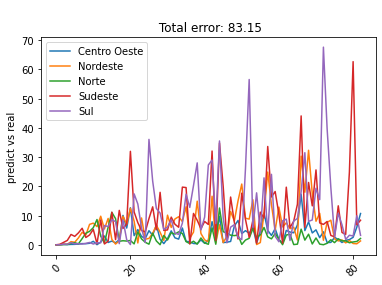

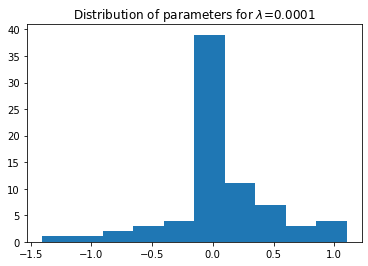

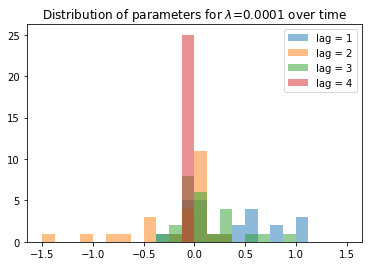

------------------------


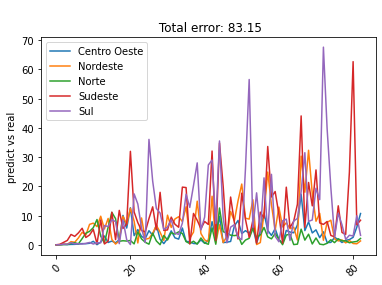

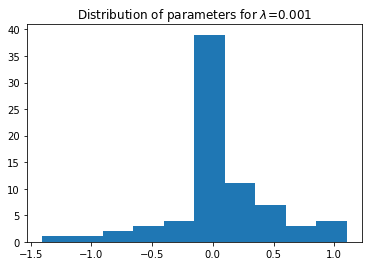

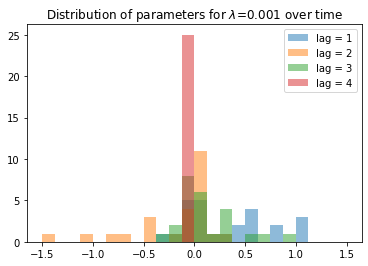

------------------------


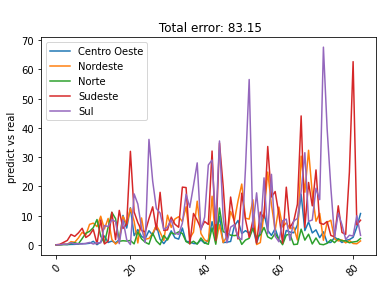

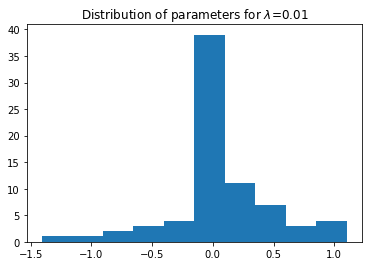

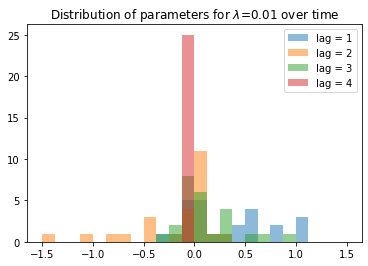

------------------------


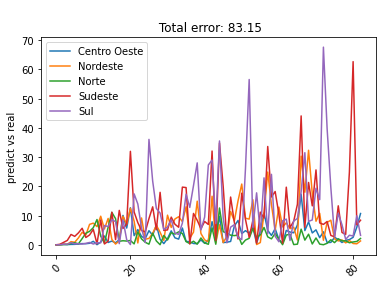

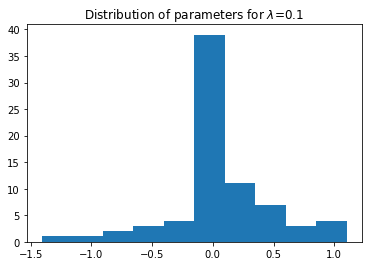

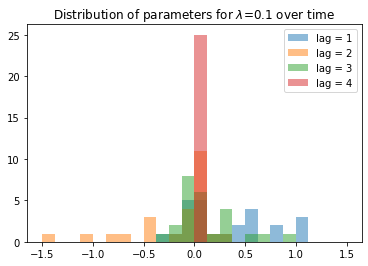

------------------------


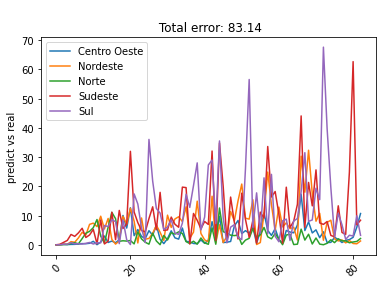

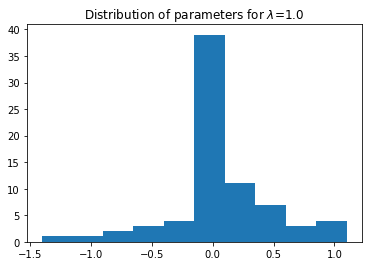

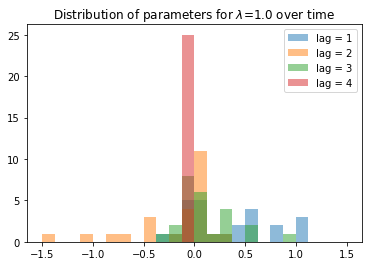

------------------------


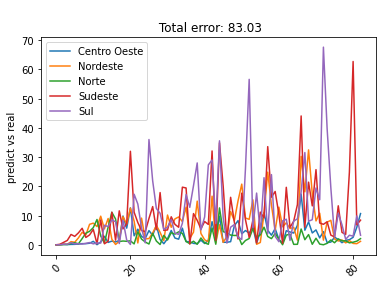

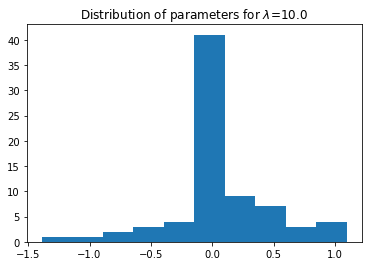

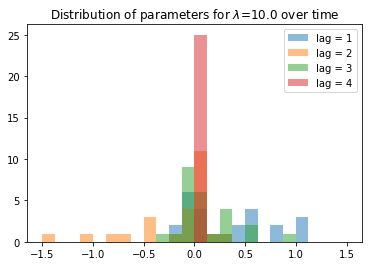

------------------------


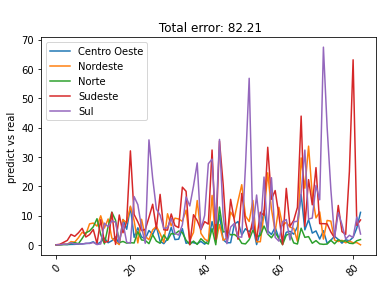

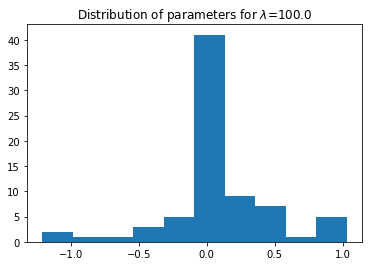

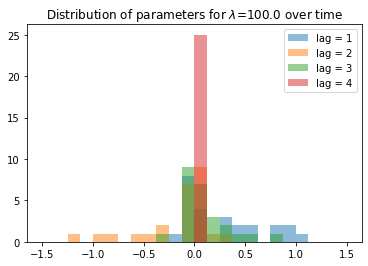

------------------------


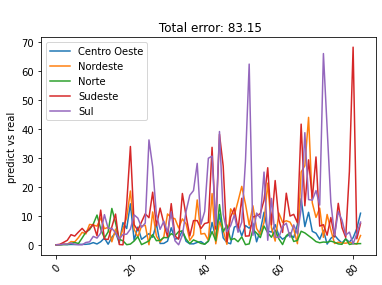

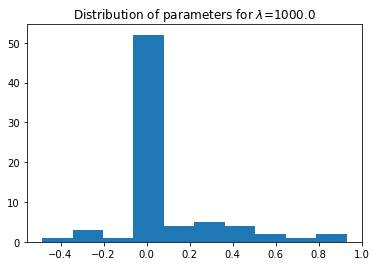

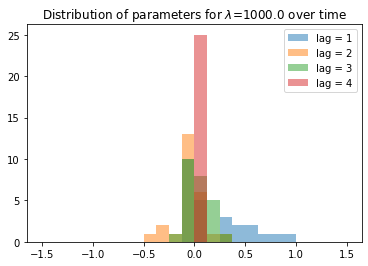

------------------------


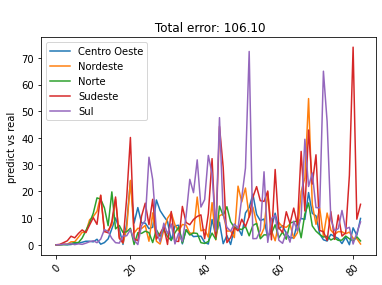

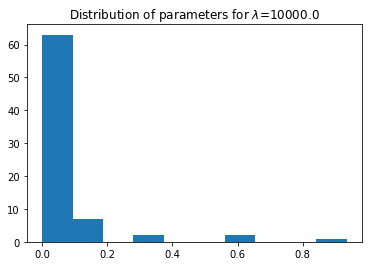

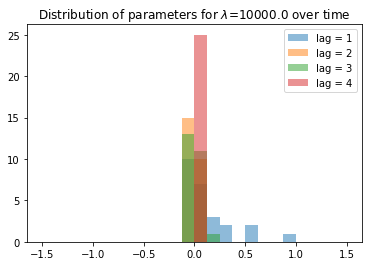

------------------------


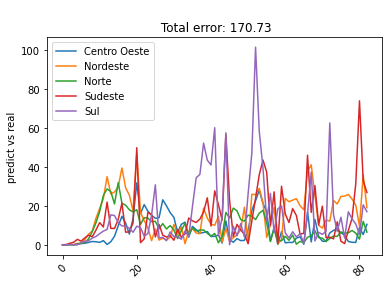

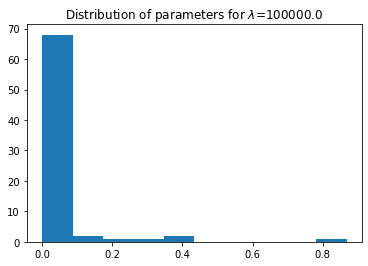

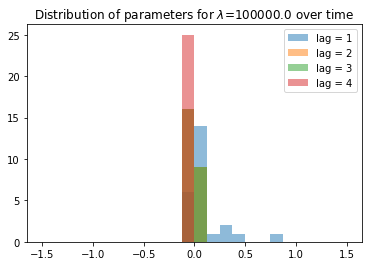

------------------------


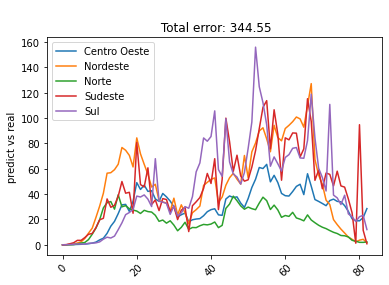

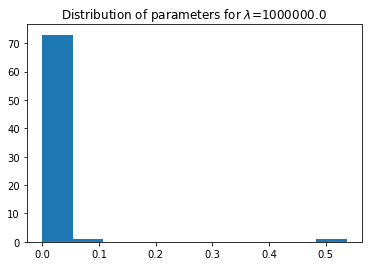

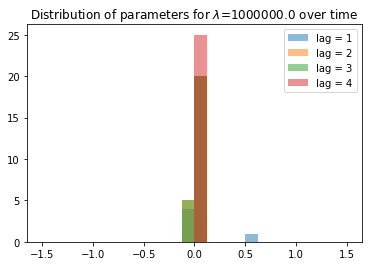

------------------------


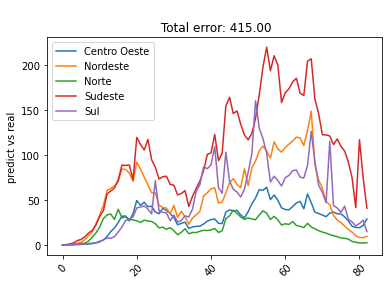

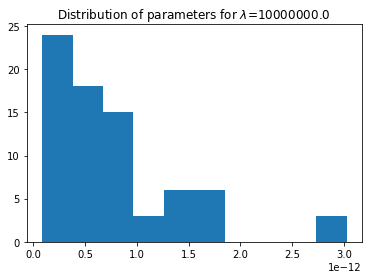

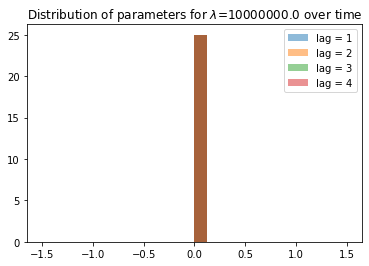

------------------------


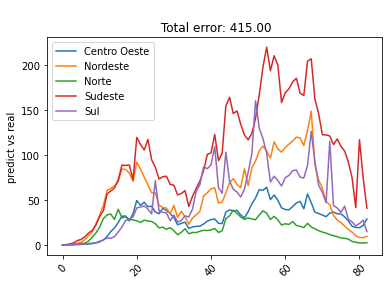

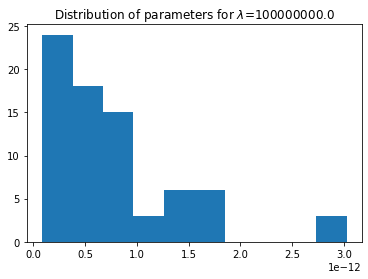

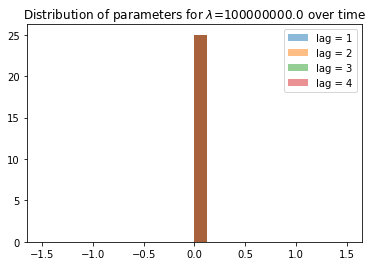

------------------------


In [59]:
no_preds = []
lambdas = np.logspace(-8,8,17)
for lambda_ in lambdas:
    constraints,C,Y_hat = make_constraints(Y.copy())
    obj = cp.Minimize(cp.sum_squares(Y_hat[:,n:] - Y[:,n:]) + lambda_*cp.norm1(cp.hstack(C)))
    p = cp.Problem(obj,constraints)
    p.solve()
    no_preds.append(np.sum(np.abs(1 - Y_hat[:,n:].value/Y[:,n:])))
    make_plot_Y(Y[:,n:],Y_hat[:,n:])
    make_plot_C(C,lambda_)
    make_plot_C_3d(C,lambda_)
    print("------------------------")

In [ ]:
plt.plot(lambdas,with_preds,label="with pred")
plt.plot(lambdas,no_preds,label="No pred")
plt.axhline(np.sum(np.abs(1 - pred[:,n:]/Y[:,n:])),label="SES")
plt.xlabel("$\lambda$")
plt.ylabel("$\sum_{i,t} 1 - \hat{Y}_{i,t} / Y_{i,t}$")
plt.legend()
plt.loglog()
plt.show()